In [1]:
import pandas as pd 
import numpy as np 
import math 
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Election details
elections = ['UK','USA-Represantatives','USA-Senat','Germany','Austria']
election_times = {
    'UK':  ['2010-05-06', '2015-05-07', '2017-06-08', '2019-12-12', '2024-07-04'],
    'USA-Represantatives': ['2012-11-06', '2014-11-04', '2016-11-08', '2018-11-06', '2020-11-03','2024-11-03'],
    'USA-Senat': ['2012-11-06', '2014-11-04', '2016-11-08', '2018-11-06', '2020-11-03','2024-11-03'],  
    'Germany':  ['2013-09-22', '2017-09-24', '2021-09-26'],
    'Austria':  ['2013-09-29', '2017-10-15', '2019-09-29', '2024-09-29']
}

files = {'UK':'../data/Final Datasets/Final Datasets/UK_politician_data.csv',
         'USA-Represantatives':'../data/Final Datasets/Final Datasets/USA-Represantatives_rep_politician_data.csv',
         'USA-Senat':'../data/Final Datasets/Final Datasets/USA-Senat_sen_politician_data.csv',
         'Germany':'../data/Final Datasets/Final Datasets/Germany_politician_data.csv', 
         'Austria':'../data/Final Datasets/Final Datasets/Austria_politician_data.csv'}

In [37]:
datasets = {}
for file in files:
    data = pd.read_csv(files[file])
    data['Date'] = pd.to_datetime(data['Date'])
    datasets[file] = data

In [38]:
## reading data
german = pd.read_csv('../data/Final Datasets/Final Datasets/Germany_politician_data.csv')
german['Date'] = pd.to_datetime(german['Date'])


In [39]:

def group_by_date(date, data, offset =3):
    """
    Gruppiert die Daten basierend auf einem Datum und einem ±3-Monats-Zeitraum.

    Args:
        date (str or pd.Timestamp): Referenzdatum.
        data (pd.DataFrame): DataFrame mit einer 'Date'-Spalte.

    Returns:
        tuple: Zwei DataFrames - innerhalb und außerhalb des Zeitraums.
    """
    
    date = pd.to_datetime(date)
    date_before = date - pd.DateOffset(months=offset)
    date_after = date + pd.DateOffset(months=offset)

    # Filtere die Daten
    values_in_date_range = data[(data['Date'] >= date_before) & (data['Date'] <= date_after)]
    values_outside_date_range = data[(data['Date'] < date_before) | (data['Date'] > date_after)]

    return values_in_date_range, values_outside_date_range

def filter_election_periods(data:pd.DataFrame,dates:list[str], offset:int = 3)->tuple[pd.DataFrame,pd.DataFrame]:
    data[(data['Date'] >= '2010-01-01') & (data['Date'] <= '2024-12-31')]
    election_data = pd.DataFrame()  
    not_election_data = data
    for date in dates:
        single_election_data, not_election_data = group_by_date(date, not_election_data, offset)
        election_data = pd.concat([election_data, single_election_data], ignore_index=True)
    return(election_data, not_election_data)



In [7]:
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    print(stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes,equal_var=False))

####UK######
TtestResult(statistic=0.10502124445267089, pvalue=0.9163589728911683, df=975633.3365920311)
####USA-Represantatives######
TtestResult(statistic=0.7969331793300528, pvalue=0.42549002059343877, df=1047538.2179299062)
####USA-Senat######
TtestResult(statistic=0.379015490214214, pvalue=0.7046765185481779, df=510787.84696113924)
####Germany######
TtestResult(statistic=2.7616597920110517, pvalue=0.005751418605617925, df=180295.13714212595)
####Austria######
TtestResult(statistic=6.541549921743174, pvalue=6.153421793553798e-11, df=45095.07121089457)


In [42]:
## hypothesen test für verschiedene offsets

p_values_elections = {
    'UK':  [],
    'USA-Represantatives': [],
    'USA-Senat': [],  
    'Germany':  [],
    'Austria':  []
}
for offset in range (10):
    for election in datasets:
        #print(f'####{election}######')
        election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],offset)
        p_values_elections[election].append(stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False).pvalue)
        #print(stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False))

    

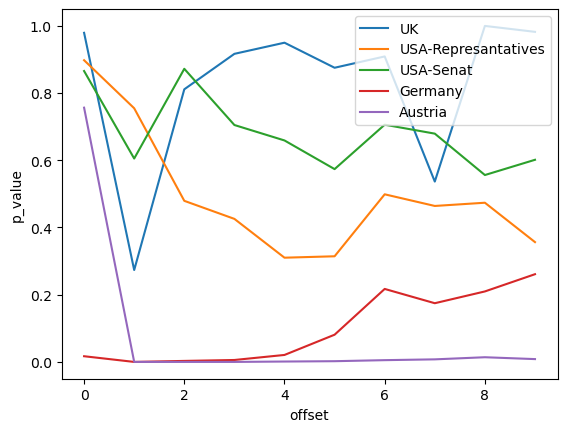

In [46]:
for election in p_values_elections:
    plt.plot(p_values_elections[election],label=election)
plt.xlabel('offset')
plt.ylabel('p_value')
plt.legend()

In [33]:
def group_by_person(election_data,not_election_data)->tuple[pd.Series,pd.Series]:
    # Berechne die Mittelwerte der Änderungen für jede Gruppe
    election_means = election_data.groupby('name')['Changes'].mean()
    not_election_means = not_election_data.groupby('name')['Changes'].mean()

    # Finde die gemeinsamen Namen in beiden DataFrames
    common_names = election_means.index.intersection(not_election_means.index)

    # Filtere die Daten auf die gemeinsamen Namen
    election_means_common = election_means.loc[common_names]
    not_election_means_common = not_election_means.loc[common_names]
    
    return (election_means_common, not_election_means_common)

In [40]:
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    election_data, not_election_data = group_by_person(election_data, not_election_data)
    print(stats.ttest_rel(a=election_data, b=not_election_data))

####UK######
TtestResult(statistic=0.15195740151561646, pvalue=0.8792463352091178, df=1188)
####USA-Represantatives######
TtestResult(statistic=0.4928952966018113, pvalue=0.6222400494603866, df=705)
####USA-Senat######
TtestResult(statistic=-0.11035391029213183, pvalue=0.9122802517008324, df=146)
####Germany######
TtestResult(statistic=10.649053761097953, pvalue=3.850377728732524e-25, df=986)
####Austria######
TtestResult(statistic=5.89037899397048, pvalue=7.66311391229748e-09, df=440)


In [35]:
election_data

name
Aaron Bell             92.000000
Abena Oppong-Asare     77.312500
Adam Afriyie           61.060976
Adam Holloway           5.244186
Adnan Hussain         195.609375
                         ...    
Yuan Yang             108.064220
Yvette Cooper          49.571053
Yvonne Fovargue        99.486486
Zac Goldsmith          17.525937
Zarah Sultana          60.914397
Name: Changes, Length: 1189, dtype: float64

In [19]:
stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False)

TtestResult(statistic=0.5478099509038079, pvalue=0.583822913722108, df=240429.81976911525)

In [25]:
print(stats.ttest_rel(a=election_means_common, b=not_election_means_common).pvalue)

7.522559514297726e-15
